In [6]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
import statsmodels.tsa.api as sm
import statsmodels
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import pmdarima as pm
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from prophet import Prophet
from tensorflow.keras.optimizers import Adam
warnings.simplefilter('ignore')

/home/phucan/miniconda3/envs/min3_ds-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read cleaned data from file

In [7]:
cleaned_df = pd.read_csv('data/data_processed.csv')
cleaned_df.head(10)

,settlement_date,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday,settlement_time,datetime
0,2009-01-01,33504,35379.0,29927,62,1403,0,0,0,1235,916,0,0,-40,0,0,1,00:00,2009-01-01 00:00:00
1,2009-01-01,37910,38704.0,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1,00:30,2009-01-01 00:30:00
2,2009-01-01,38047,38964.0,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1,01:00,2009-01-01 01:00:00
3,2009-01-01,37380,38651.0,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1,01:30,2009-01-01 01:30:00
4,2009-01-01,36426,37775.0,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1,02:00,2009-01-01 02:00:00
5,2009-01-01,35687,37298.0,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1,02:30,2009-01-01 02:30:00
6,2009-01-01,35408,37135.0,31604,43,1403,0,0,0,967,1754,0,0,-160,0,0,1,03:00,2009-01-01 03:00:00
7,2009-01-01,34322,36844.0,30486,43,1403,0,0,0,1762,1754,0,0,-160,0,0,1,03:30,2009-01-01 03:30:00
8,2009-01-01,33076,35678.0,29390,56,1403,0,0,0,1842,1755,0,0,-160,0,0,1,04:00,2009-01-01 04:00:00
9,2009-01-01,31970,34635.0,28452,56,1403,0,0,0,1905,1755,0,0,-160,0,0,1,04:30,2009-01-01 04:30:00


In [8]:
# convert the date column to datetime
cleaned_df['settlement_date'] = pd.to_datetime(cleaned_df['settlement_date'])

### Visualize the data

#### Analyze electricity demand over time

Text(0, 0.5, 'Transmission System Demand (MWh)')

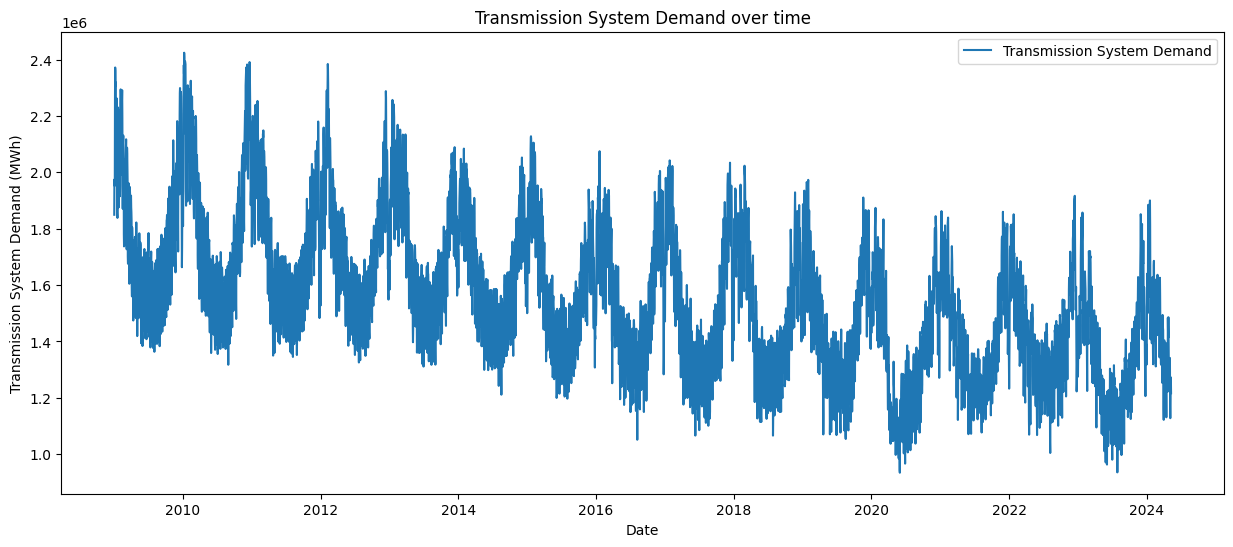

In [4]:
#cleaned_df = cleaned_df.set_index('settlement_date')
# plot tsd and nd using sns
cleaned_df.reset_index(inplace=True)
plt.figure(figsize=(15, 6))
tsdPlotDat = cleaned_df["tsd"].groupby(cleaned_df["settlement_date"]).sum()
sns.lineplot(data=tsdPlotDat, label='Transmission System Demand')
plt.title('Transmission System Demand over time')
plt.xlabel('Date')
plt.ylabel('Transmission System Demand (MWh)')


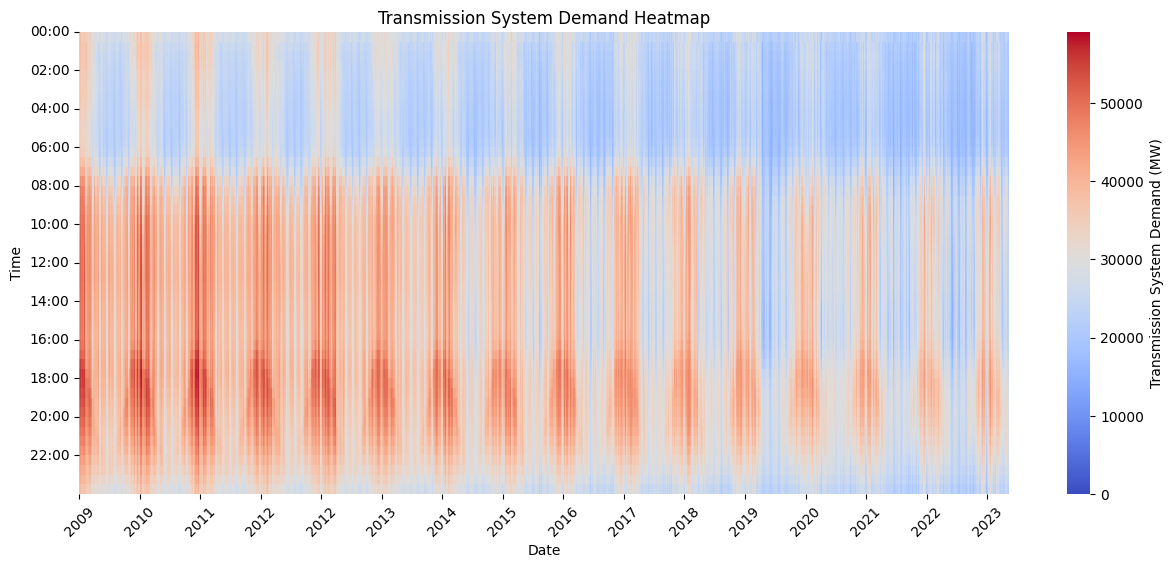

In [5]:
# plot tsd heatmap
# create a pivot table
pivot_tsd = cleaned_df.pivot_table(index='settlement_time', columns='settlement_date', values='nd', aggfunc='sum')
pivot_tsd = pivot_tsd.fillna(0)
pivot_tsd = pivot_tsd.sort_index(ascending=True)
plt.figure(figsize=(15, 6))
ax=sns.heatmap(pivot_tsd, cmap='coolwarm')
ax.collections[0].colorbar.set_label('Transmission System Demand (MW)')
plt.title('Transmission System Demand Heatmap')
# format date on x-axis to only show year
plt.xticks(np.arange(0, len(pivot_tsd.columns), 365), [x.strftime('%Y') for x in pivot_tsd.columns[::365]])
plt.xticks(rotation=45)
# format time on y-axis to only show 2 hours
plt.yticks(np.arange(0, len(pivot_tsd.index), 4), pivot_tsd.index[::4])
plt.xlabel('Date')
plt.ylabel('Time')
plt.show()

Plot the transmission demand over time to see if there are any trends or patterns.

Plot the transmission demand minus net demand

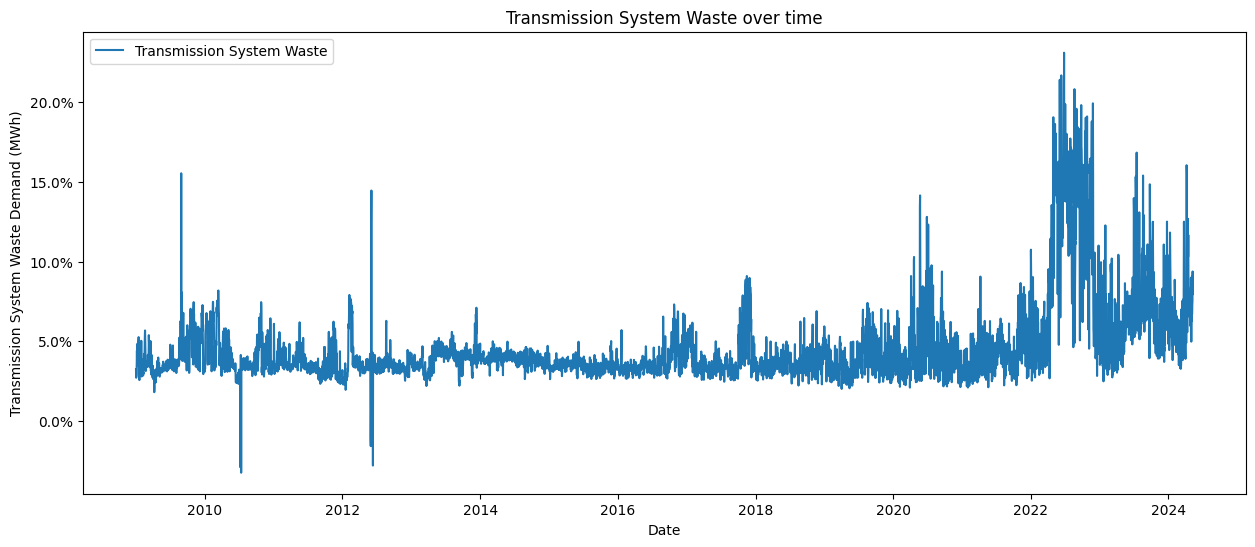

In [6]:
#cleaned_df = cleaned_df.set_index('settlement_date')
# plot tsd and nd using sns
plt.figure(figsize=(15, 6))
transmissionSystemWastePercentage = (cleaned_df["tsd"].groupby(cleaned_df["settlement_date"]).sum() - cleaned_df["nd"].groupby(cleaned_df["settlement_date"]).sum())/cleaned_df["tsd"].groupby(cleaned_df["settlement_date"]).sum()
sns.lineplot(data=transmissionSystemWastePercentage, label='Transmission System Waste')
plt.title('Transmission System Waste over time')
plt.xlabel('Date')
plt.ylabel('Transmission System Waste Demand (MWh)')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))




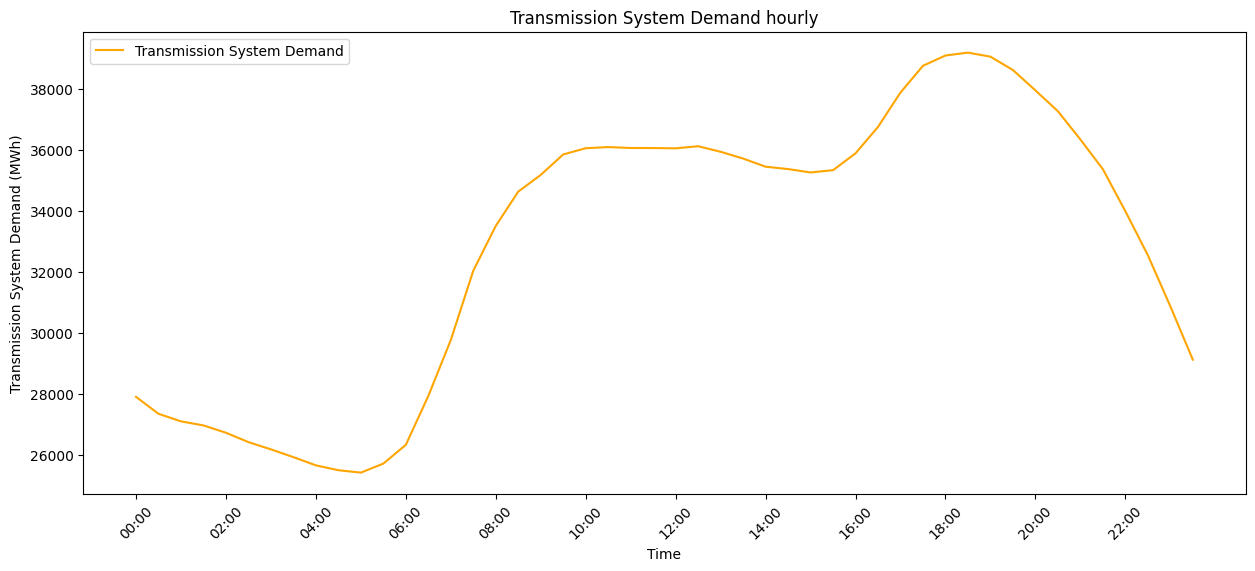

In [7]:
#cleaned_df = cleaned_df.set_index('settlement_date')
# plot tsd groupby hourly
plt.figure(figsize=(15, 6))
tsdPlotDat = cleaned_df["tsd"].groupby(cleaned_df["settlement_time"]).mean()
sns.lineplot(data=tsdPlotDat, label='Transmission System Demand', color='orange')
plt.title('Transmission System Demand hourly')
plt.xlabel('Time')
plt.ylabel('Transmission System Demand (MWh)')
plt.xticks(rotation=45);
plt.xticks(np.arange(0, len(tsdPlotDat), 4), tsdPlotDat.index[::4]);


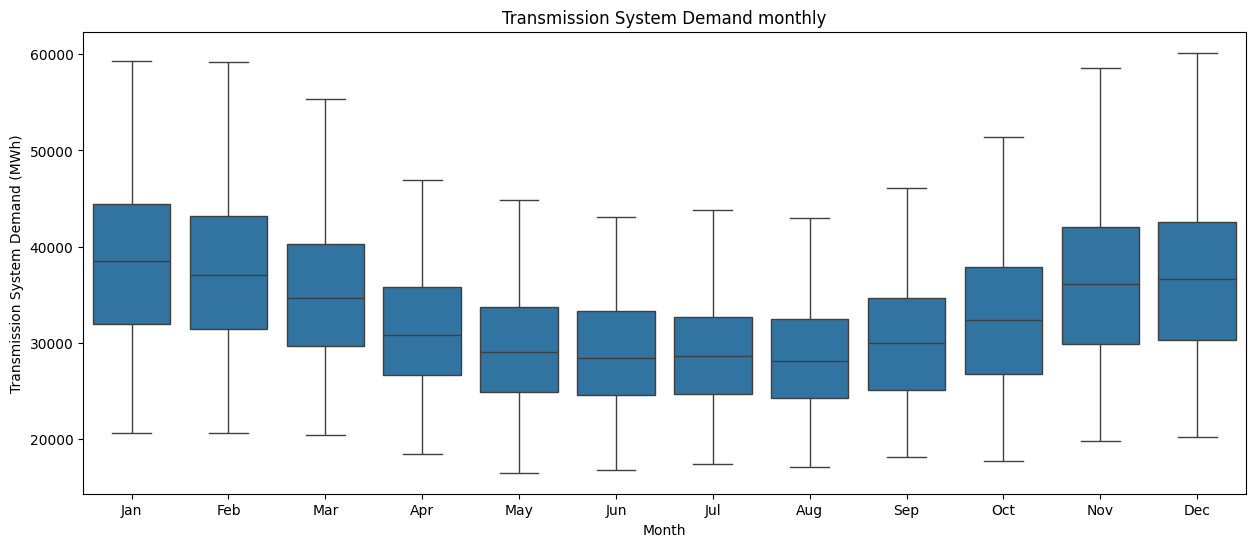

In [8]:
#cleaned_df = cleaned_df.set_index('settlement_date')
# plot tsd groupby monthly on boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(x=cleaned_df["settlement_date"].dt.month, y=cleaned_df["tsd"])
plt.title('Transmission System Demand monthly')
plt.xlabel('Month')
plt.ylabel('Transmission System Demand (MWh)')
plt.xticks(np.arange(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);
plt.show()


### Model predict Transmission System Demand

In [9]:
df_sarima = cleaned_df.groupby('settlement_date')[['tsd', 'is_holiday']].sum()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year
df_sarima["is_holiday"] = (df_sarima["is_holiday"]/48).astype('int')

In [10]:
df_sarima

,tsd,is_holiday,month,year
settlement_date,,,,
2009-01-01,1849363.0,1,1,2009
2009-01-02,1974406.0,0,1,2009
2009-01-03,1952054.0,0,1,2009
2009-01-04,1968670.0,0,1,2009
2009-01-05,2271471.0,0,1,2009
...,...,...,...,...
2024-05-05,1127825.0,0,5,2024
2024-05-06,1193789.0,1,5,2024
2024-05-07,1273079.0,0,5,2024


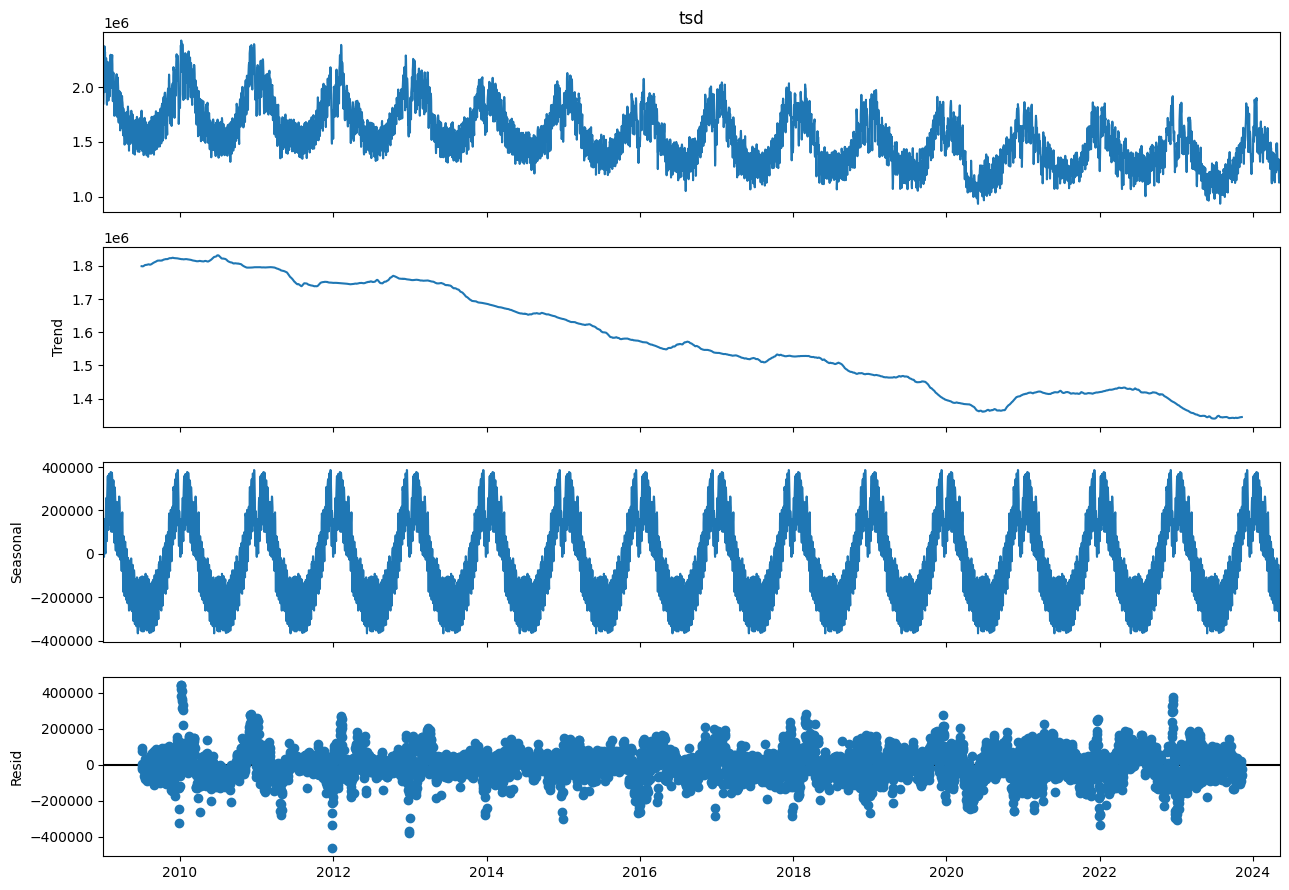

In [11]:
decompose = sm.seasonal_decompose(df_sarima["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()


In [12]:
threshold_date = "01-01-2021"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

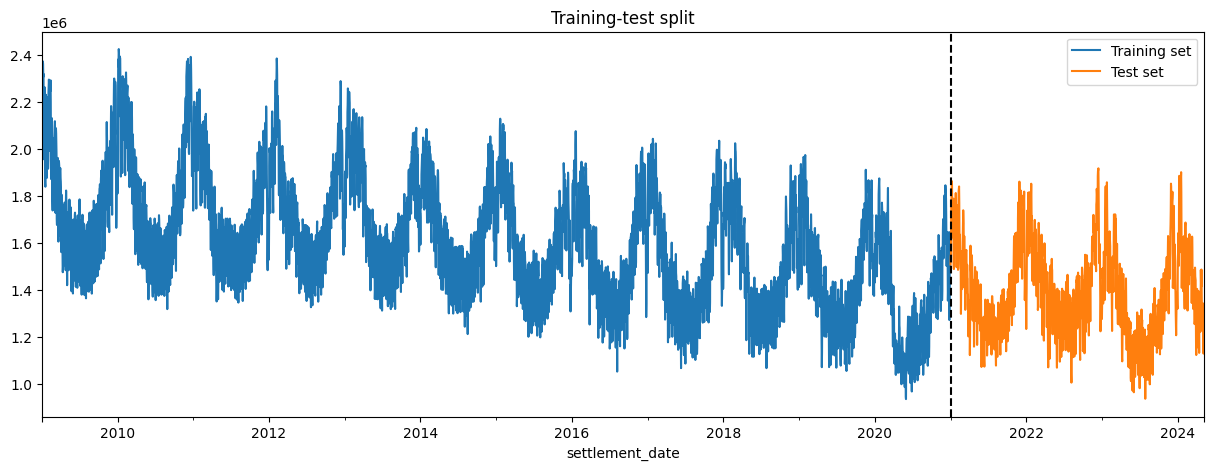

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label="Training set")
test_data.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

In [14]:
# # def mean_absolute_percentage_error(y_true, y_pred):
# #     """
# #     Calculate Mean Absolute Pertange Error given the true and
# #     predicted values

# #     Args:
# #         - y_true: true values
# #         - y_pred: predicted values

# #     Returns:
# #         - mape: MAPE value for the given predicted values
#     """
# # 
# #     y_true, y_pred = np.array(y_true), np.array(y_pred)
# #     mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# #     return mape

In [15]:
# def stats_test(sar_model):
#     """
#     Perform statistical tests on SARIMA model and print the results

#     Args:
#         - sar_model: SARIMA model
#     """

#     # create and run statistical tests on model
#     norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
#     lb_val, lb_p = sar_model.test_serial_correlation(
#         method="ljungbox",
#     )[0]
#     het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

#     # we want to look at largest lag for Ljung-Box, so take largest number in series
#     # there's intelligence in the method to determine how many lags back to calculate this stat
#     lb_val = lb_val[-1]
#     lb_p = lb_p[-1]
#     durbin_watson = statsmodels.stats.stattools.durbin_watson(
#         sar_model.filter_results.standardized_forecasts_error[
#             0, sar_model.loglikelihood_burn :
#         ]
#     )

#     print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
#     print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
#     print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
#     print("Durbin-Watson: d={:.2f}".format(durbin_watson))


# def create_predict_analyse(
#     timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
# ):
#     """
#     Create SARIMA model and perform the following actions:
#         - Perform statisticals tests to check if the model parameters are right
#         - Plot model diagnostics
#         - Predict on test data
#         - Compute MAPE
#         - Plot test data, prediction and confidence interval

#     Args:
#         - timeseries: time series data
#         - order: SARIMA order parameters
#         - seasonal_order: SARIMA seasonal order parameters
#         - max_iter: maximum number of iterations to compute SARIMA values
#         - lags: number of lags used for model diagnostics
#         - test_data: test data
#         - disp_flag: boolean variable to display SARIMA model iterations

#     Returns:
#         - execution_time: SARIMA model runtime
#         - mape: MAPE on test data
#         - sarima_model: SARIMA model created using the function arguments
#     """

#     # Create and fit SARIMA model
#     start_time = datetime.datetime.now()
#     sarima_model = sm.statespace.SARIMAX(
#         timeseries, order=order, seasonal_order=seasonal_order
#     ).fit(maxiter=max_iter, disp=disp_flag)
#     execution_time = datetime.datetime.now() - start_time

#     # Perform statistical tests on model
#     stats_test(sarima_model)
#     print("-------------------------------------------------------------")

#     # Plot SARIMA model diagnostics
#     sarima_model.plot_diagnostics(
#         lags=lags,
#         figsize=(20, 12),
#     )

#     # Predict on test data
#     predict = sarima_model.get_prediction(
#         start="01-01-2021", end=str(test_data.index[-1].date())
#     )
#     confidence_int = predict.conf_int(alpha=0.05)
#     prediction = predict.predicted_mean

#     # Calculate MAPE on test data
#     mape = mean_absolute_percentage_error(test_data.values, prediction.values)

#     # Plot test data, predictions and confidence interval
#     fig, ax = plt.subplots(figsize=(10, 5))
#     ax.plot(prediction, label="Prediction")
#     ax.plot(test_data, label="Test data")
#     ax.fill_between(
#         confidence_int.index,
#         confidence_int["lower tsd"],
#         confidence_int["upper tsd"],
#         alpha=0.3,
#     )
#     ax.set_title("Prediction on test data")
#     ax.set_ylabel("Total power consumption (MW)")
#     ax.legend()

#     return execution_time, mape, sarima_model

In [16]:
# [execution_time_0, mape_0, sarima_model_0] = create_predict_analyse(
#     train_data, (1, 0, 1), (1, 0, 1, 12), 75, 31, test_data, False
# )

In [17]:
order = (1, 0, 1)  # (p, d, q)
seasonal_order = (1, 0, 1, 12)  # (P, D, Q, m)
model = SARIMAX(df_sarima['tsd'], order=order, seasonal_order=seasonal_order)

In [18]:
results = model.fit()

In [19]:
predict_steps = 365
predict = results.get_forecast(steps=predict_steps)

In [20]:
predict_values = predict.predicted_mean
confidence_intervals = predict.conf_int()
print(predict_values)

2024-05-10    1.230064e+06
2024-05-11    1.215363e+06
2024-05-12    1.236244e+06
2024-05-13    1.219637e+06
2024-05-14    1.225823e+06
                  ...     
2025-05-05    8.716914e+05
2025-05-06    8.708052e+05
2025-05-07    8.699199e+05
2025-05-08    8.690356e+05
2025-05-09    8.681521e+05
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


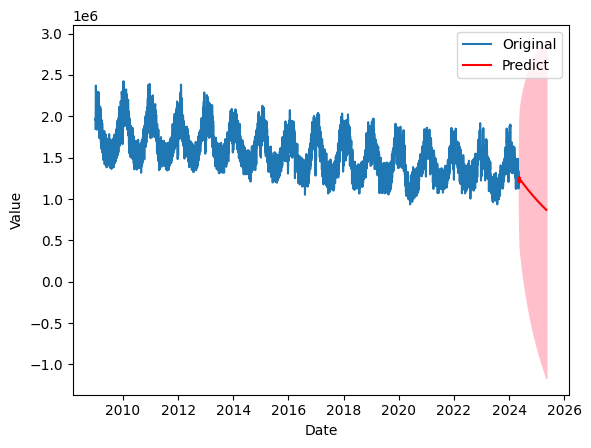

In [21]:
plt.plot(df_sarima.index, df_sarima['tsd'], label='Original')
plt.plot(predict_values.index, predict_values, label='Predict', color='red')
plt.fill_between(predict_values.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [22]:
sam = df_sarima['tsd']


In [23]:
model = pm.auto_arima(sam, 
                      seasonal=True,  # Set to True if the data has seasonality
                      trace=True,      # If you want to see the process
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)   # Stepwise search to reduce computation time

# Summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=145141.355, Time=4.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=146654.927, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=146591.377, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=146448.068, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=146652.932, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=145243.279, Time=1.91 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=144818.457, Time=1.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=146166.662, Time=1.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=145660.863, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=144820.443, Time=2.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=145625.805, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=145231.414, Time=2.90 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=144816.279, Time=1.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=146164.667, Time=0.94 sec
 ARIM

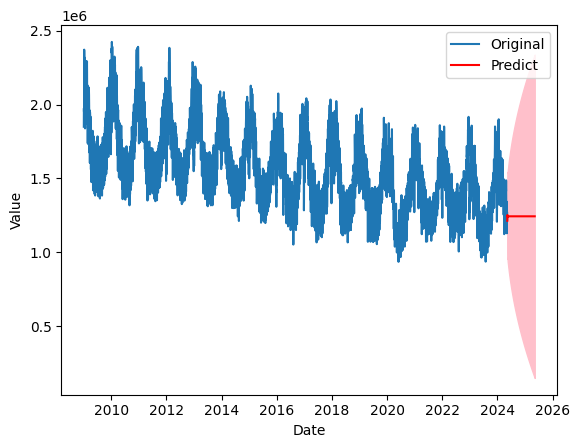

In [24]:
n_forecasts = 365
forecast, conf_int = model.predict(n_periods=n_forecasts, return_conf_int=True)
conf_int = pd.DataFrame(conf_int)
plt.plot(df_sarima['tsd'].index, df_sarima['tsd'], label='Original')
plt.plot(forecast.index, forecast, label='Predict', color='red')
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [25]:
# df_sarima = df_sarima.set_index('settlement_date')

In [26]:
# df_sarima

In [27]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df_sarima.loc[df_sarima.index < threshold_date_1]
test_data = df_sarima.loc[(df_sarima.index >= threshold_date_1) & (df_sarima.index < threshold_date_2)]
hold_out_data = df_sarima.loc[df_sarima.index >= threshold_date_2]

# Define the features and target variable
FEATURES = [
    "is_holiday",
    "year",
    "month"
]
TARGET = "tsd"

FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_lstm = train_data[FEATURES_TARGET]
test_data_lstm = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0,1))
train_data_lstm_scale = scaler.fit_transform(train_data_lstm.values)
test_data_lstm_scale = scaler.transform(test_data_lstm.values)

X_train_keras = (
    train_data_lstm_scale[:,:-1].
    reshape(train_data_lstm_scale.shape[0],1,len(FEATURES))
)
y_train_keras = train_data_lstm_scale[:,-1]

X_test_keras = (
    test_data_lstm_scale[:,:-1].
    reshape(test_data_lstm_scale.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_lstm_scale[:,-1]

In [28]:
tf.random.set_seed(221)

# Create and compite neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer="adam")


# Fit model
history = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.1689 - val_loss: 0.0747
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0620 - val_loss: 0.0995
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0520 - val_loss: 0.0701
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0449 - val_loss: 0.0549
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0378 - val_loss: 0.0405
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0325 - val_loss: 0.0305
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0287 - val_loss: 0.0261
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0268 - val_loss: 0.0251
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0264 - val_loss: 0.0249
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0266 - val_loss: 0.0249
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0265 - val_loss: 0.0247
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

In [29]:
# Prediction on test set
pred_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_lstm = test_data_lstm_scale
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

# Store inverse transformed preductons in the result dataframe
# result_frame["pred_lstm"] = results_lstm[:,-1]

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


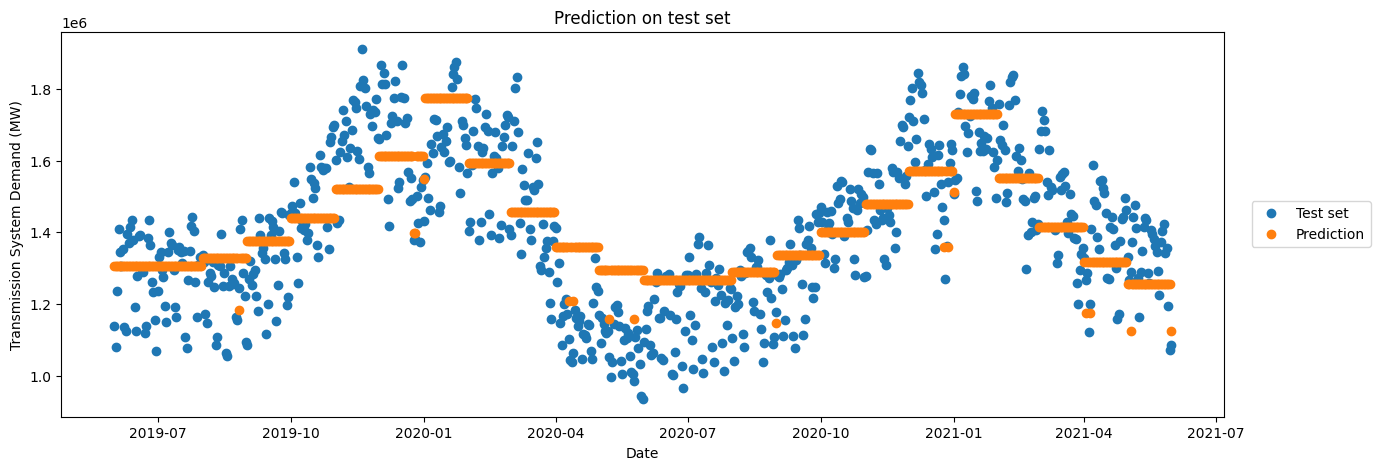

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_data.index, test_data["tsd"], "o", label="Test set")
ax.plot(test_data.index, results_lstm[:,-1], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Transmission System Demand (MW)")
ax.set_xlabel("Date");

In [33]:
holiday_df = cleaned_df[cleaned_df['is_holiday']==1]
holiday_df['holiday'] = 'holiday'
holiday_df.reset_index(inplace=True)
holiday_df.rename(columns={'level_0': 'ds'}, inplace=True)
holiday_df[['ds', 'holiday']]

,ds,holiday
0,0,holiday
1,1,holiday
2,2,holiday
3,3,holiday
4,4,holiday
...,...,...
6187,269003,holiday
6188,269004,holiday
6189,269005,holiday
6190,269006,holiday


In [35]:
cleaned_df.index = pd.to_datetime(cleaned_df.index)
cleaned_df["month"] = cleaned_df.index.month
cleaned_df["year"] = cleaned_df.index.year
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "month",
    "year"
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

X_all = cleaned_df[FEATURES]
y_all = cleaned_df[TARGET]
train_data_prophet = y_train.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
test_data_prophet = y_test.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
hold_out_data_prophet = y_hold_out.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
all_data_prophet = y_all.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

16:29:24 - cmdstanpy - INFO - Chain [1] start processing
16:29:25 - cmdstanpy - INFO - Chain [1] done processing


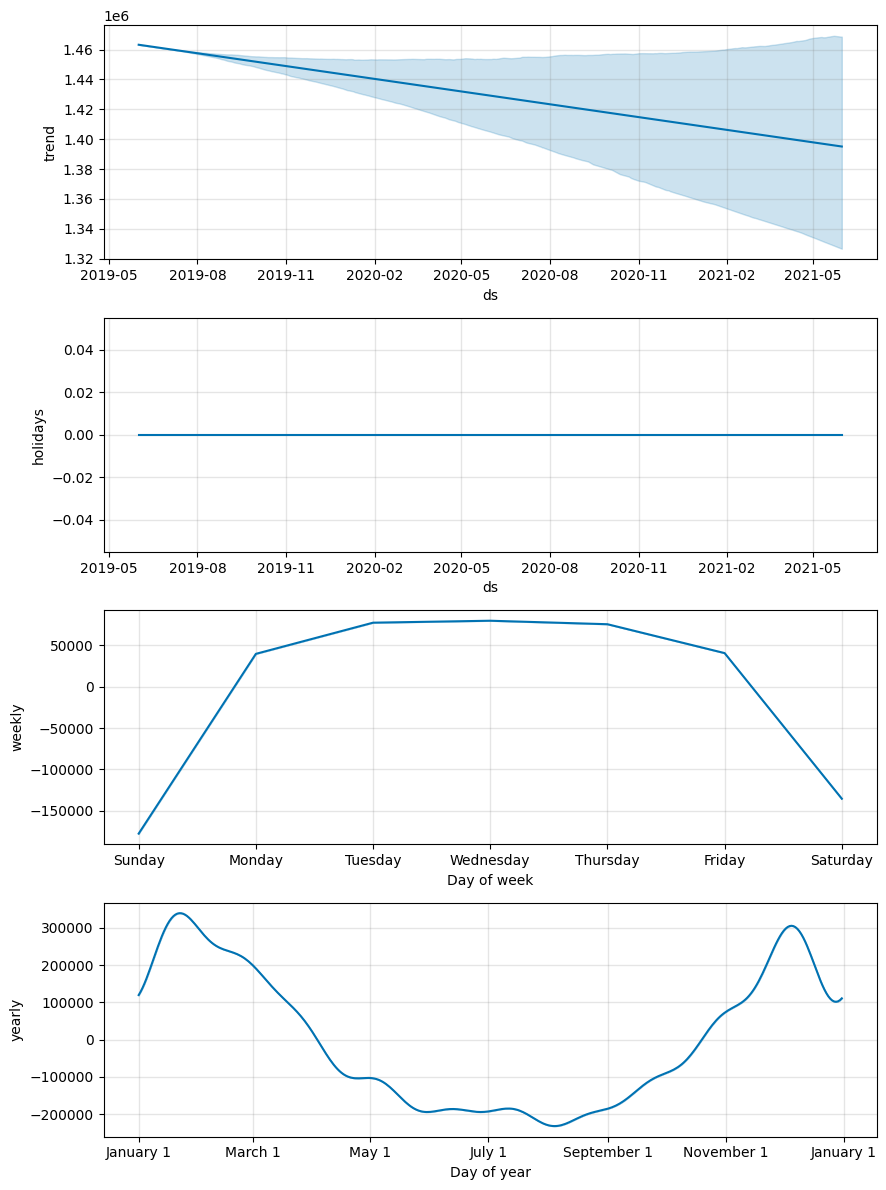

In [36]:
prophet_model = Prophet(holidays=holiday_df)
prophet_model.fit(train_data_prophet)

np.random.seed(43)
prophet_predict_df = prophet_model.predict(test_data_prophet)
prophet_predict_df.head()
prophet_model.plot_components(prophet_predict_df);

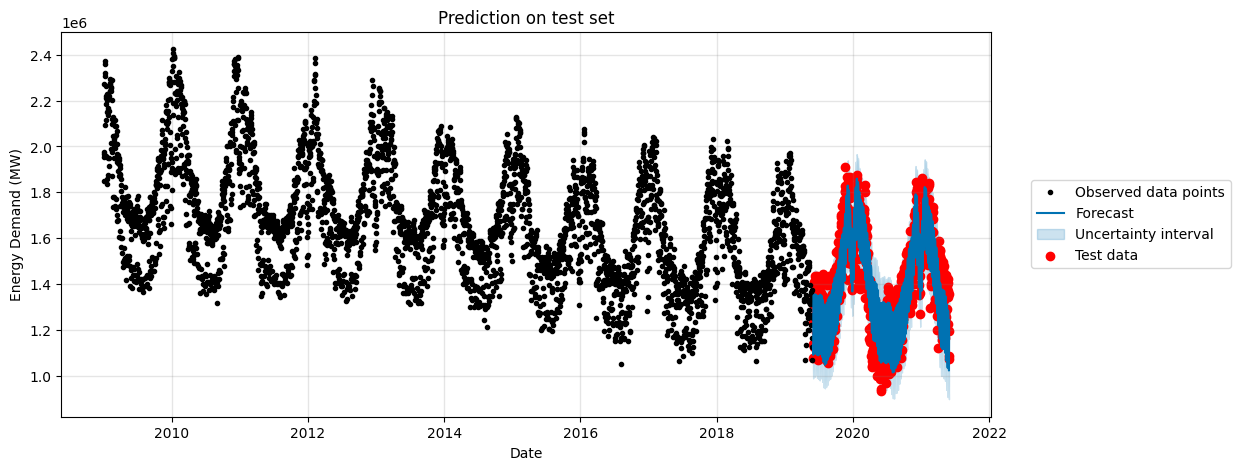

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.15, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

<Axes: xlabel='settlement_date'>

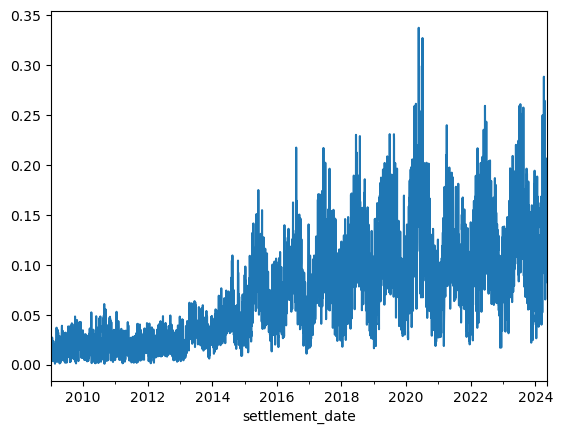

In [12]:
renewable = cleaned_df.groupby('settlement_date').sum()
renewable_percentage = (renewable['embedded_wind_generation'] + renewable['embedded_solar_generation']) / renewable['tsd']
renewable_percentage.plot()

In [16]:
renewable['renewable_percentage'] = (renewable['embedded_wind_generation'] + renewable['embedded_solar_generation']) / renewable['tsd']
a = renewable['renewable_percentage']
a

settlement_date
2009-01-01    0.001704
2009-01-02    0.007108
2009-01-03    0.004558
2009-01-04    0.008055
2009-01-05    0.010754
                ...   
2024-05-05    0.115109
2024-05-06    0.098449
2024-05-07    0.114354
2024-05-08    0.141052
2024-05-09    0.160832
Name: renewable_percentage, Length: 5608, dtype: float64

In [22]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 60  # Number of time steps to look back
scaler = MinMaxScaler(feature_range=(0, 1))

renewable['renewable_percentage'] = scaler.fit_transform(renewable[['renewable_percentage']])
data_values = renewable['renewable_percentage'].values

sequences, labels = create_sequences(data_values, sequence_length)

# Reshape sequences to be [samples, time steps, features]
sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))

In [23]:
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 256)           264192    
                                                                 
 dropout_2 (Dropout)         (None, 60, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                61400     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 325,643
Trainable params: 325,643
Non-trainable params: 0
_________________________________________________________________


2024-06-08 17:52:16.101405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-08 17:52:16.103257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-08 17:52:16.104371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [24]:
# Split the data into training and testing sets
train_size = int(len(sequences) * 0.8)
test_size = len(sequences) - train_size

train_sequences = sequences[:train_size]
train_labels = labels[:train_size]

test_sequences = sequences[train_size:]
test_labels = labels[train_size:]

# Train the model
history = model.fit(train_sequences, train_labels, epochs=20, batch_size=32, validation_data=(test_sequences, test_labels))

Epoch 1/20


2024-06-08 17:52:17.004649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-08 17:52:17.007893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-08 17:52:17.009109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

139/139 [==============================] - ETA: 0s - loss: 0.0073

2024-06-08 17:52:34.753522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-08 17:52:34.755549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-08 17:52:34.757387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

139/139 [==============================] - 20s 126ms/step - loss: 0.0073 - val_loss: 0.0129
Epoch 2/20
139/139 [==============================] - 16s 117ms/step - loss: 0.0062 - val_loss: 0.0147
Epoch 3/20
139/139 [==============================] - 16s 117ms/step - loss: 0.0059 - val_loss: 0.0119
Epoch 4/20
139/139 [==============================] - 16s 117ms/step - loss: 0.0057 - val_loss: 0.0111
Epoch 5/20
139/139 [==============================] - 16s 118ms/step - loss: 0.0055 - val_loss: 0.0103
Epoch 6/20
139/139 [==============================] - 16s 117ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 7/20
139/139 [==============================] - 16s 117ms/step - loss: 0.0047 - val_loss: 0.0096
Epoch 8/20
139/139 [==============================] - 16s 118ms/step - loss: 0.0048 - val_loss: 0.0095
Epoch 9/20
139/139 [==============================] - 16s 118ms/step - loss: 0.0045 - val_loss: 0.0095
Epoch 10/20
139/139 [==============================] - 16s 118ms/step - loss: 0.0047

2024-06-08 18:09:12.810179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-08 18:09:12.812243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-08 18:09:12.813700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

35/35 [==============================] - 2s 45ms/step


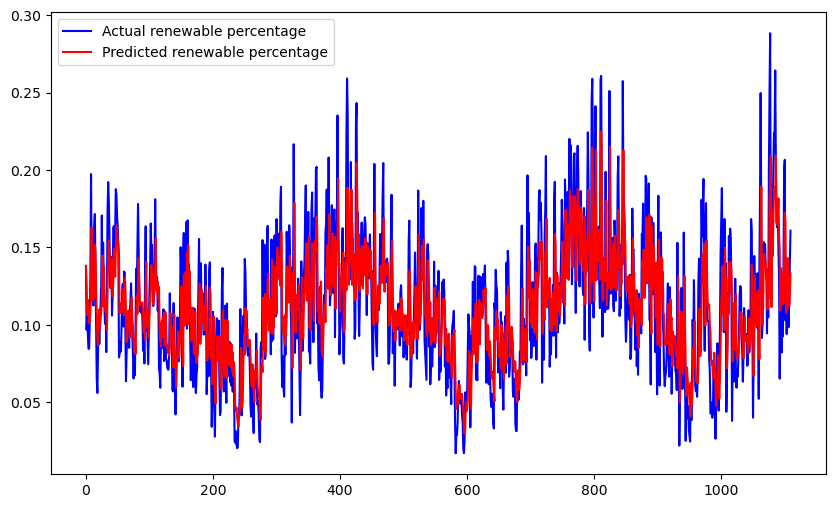

In [25]:
# Make predictions
predictions = model.predict(test_sequences)

# Inverse transform the predictions and labels to original scale
predictions = scaler.inverse_transform(predictions)
test_labels = scaler.inverse_transform(test_labels.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(test_labels, color='blue', label='Actual renewable percentage')
plt.plot(predictions, color='red', label='Predicted renewable percentage')
plt.legend()
plt.show()

In [ ]:
df_sarima = cleaned_df.groupby('settlement_date')[['tsd', 'is_holiday']].sum()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year
df_sarima["is_holiday"] = (df_sarima["is_holiday"]/48).astype('int')